In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors

import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics.scorer import make_scorer

from lmfit.models import VoigtModel

import os

In [2]:
BARREL_MAX_ETA = 0.9
ENDCAP_MIN_ETA = 1.2

FR_OUTLIERS = 0.3
Q_OVER_PT_RES_GAIN = 0.05

REFITS = ["dyt",
          "picky",
          "inner",
          "tpfms",
          "tuneP"]

P_BINS = [0., 100., 200., 300., 400., 500., 700., 1000., 1500., 2000., 3000., 4000.]

INPUT_FILE = "/eos/cms/store/user/battilan/MuonPOG/HighPtMachineLearning/data_frame_mu_plus_and_minus.csv"

OUTPUT_FOLDER = "./results/high-pT/"
if not os.path.isdir(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)

pd.set_option('mode.chained_assignment', None)

In [3]:
data_f = pd.read_csv(INPUT_FILE)

data_f = data_f.sample(frac=1, random_state=32299).reset_index(drop=True)

In [4]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

data_f.head(20)

,gen_charge,gen_eta,gen_p,gen_pt,gen_qOverPt,mu_dyt_charge,mu_dyt_chi2,mu_dyt_eta,mu_dyt_nMuHits,mu_dyt_nPixHits,mu_dyt_nTrkLays,mu_dyt_pt,mu_dyt_ptErrOverPt,mu_dyt_qOverPt,mu_eta,mu_inner_charge,mu_inner_chi2,mu_inner_eta,mu_inner_nMuHits,mu_inner_nPixHits,mu_inner_nTrkLays,mu_inner_pt,mu_inner_ptErrOverPt,mu_inner_qOverPt,mu_nDigis_CSC_st1,mu_nDigis_CSC_st2,mu_nDigis_CSC_st3,mu_nDigis_CSC_st4,mu_nDigis_DT_st1,mu_nDigis_DT_st2,mu_nDigis_DT_st3,mu_nDigis_DT_st4,mu_picky_charge,mu_picky_chi2,mu_picky_eta,mu_picky_nMuHits,mu_picky_nPixHits,mu_picky_nTrkLays,mu_picky_pt,mu_picky_ptErrOverPt,mu_picky_qOverPt,mu_pt,mu_pull_CSC_st1,mu_pull_CSC_st2,mu_pull_CSC_st3,mu_pull_CSC_st4,mu_pull_DT_st1,mu_pull_DT_st2,mu_pull_DT_st3,mu_pull_DT_st4,mu_tpfms_charge,mu_tpfms_chi2,mu_tpfms_eta,mu_tpfms_nMuHits,mu_tpfms_nPixHits,mu_tpfms_nTrkLays,mu_tpfms_pt,mu_tpfms_ptErrOverPt,mu_tpfms_qOverPt,mu_tuneP_charge,mu_tuneP_chi2,mu_tuneP_eta,mu_tuneP_nMuHits,mu_tuneP_nPixHits,mu_tuneP_nTrkLays,mu_tuneP_pt,mu_tuneP_ptErrOverPt,mu_tuneP_qOverPt
0,-1.0,1.577858,3545.480049,1403.876587,-0.000712,-1.0,1.054633,1.578022,16.0,4.0,15.0,1472.843384,0.083345,-0.000679,1.578022,-1.0,1.073147,1.578020,0.0,4.0,15.0,1523.083252,0.226865,-0.000657,14.0,0.0,82.0,10.0,0.0,0.0,0.0,0.0,-1.0,0.922051,1.578022,22.0,4.0,15.0,1472.821899,0.082671,-0.000679,1472.821899,-0.258792,30.000000,-0.083891,0.187359,30.000000,30.000000,30.000000,30.000000,-1.0,0.922634,1.578028,14.0,4.0,15.0,1478.037354,0.075440,-0.000677,-1.0,0.922051,1.578022,22.0,4.0,15.0,1472.821899,0.082671,-0.000679
1,1.0,-2.051265,762.913087,192.988419,0.005182,1.0,0.607914,-2.051490,18.0,9.0,16.0,175.339508,0.042370,0.005703,-2.051491,1.0,0.630278,-2.051491,0.0,9.0,16.0,174.557465,0.046119,0.005729,20.0,31.0,12.0,14.0,0.0,0.0,0.0,0.0,1.0,0.578697,-2.051495,14.0,9.0,16.0,174.863159,0.042679,0.005719,174.557465,0.333220,-0.122612,-0.097712,0.289783,30.000000,30.000000,30.000000,30.000000,1.0,0.592953,-2.051491,8.0,9.0,16.0,174.577133,0.042485,0.005728,1.0,0.630278,-2.051491,0.0,9.0,16.0,174.557465,0.046119,0.005729
2,-1.0,1.354608,3238.874279,1567.213257,-0.000638,-1.0,0.621925,1.354639,24.0,5.0,13.0,1440.128296,0.058257,-0.000694,1.354638,-1.0,0.884386,1.354640,0.0,5.0,13.0,1451.026123,0.143116,-0.000689,17.0,15.0,15.0,14.0,0.0,0.0,0.0,0.0,-1.0,0.595697,1.354638,28.0,5.0,13.0,1440.392090,0.058188,-0.000694,1440.392090,-0.232344,0.052295,0.098233,0.069163,30.000000,30.000000,30.000000,30.000000,-1.0,0.735964,1.354643,7.0,5.0,13.0,1427.533447,0.064559,-0.000701,-1.0,0.595697,1.354638,28.0,5.0,13.0,1440.392090,0.058188,-0.000694
3,-1.0,1.000109,2481.554476,1608.048828,-0.000622,-1.0,1.744989,1.000152,22.0,5.0,12.0,1596.966553,0.061547,-0.000626,1.000153,-1.0,1.292580,1.000065,0.0,5.0,12.0,2402.830322,0.356812,-0.000416,142.0,0.0,0.0,0.0,7.0,8.0,0.0,0.0,-1.0,1.477473,1.000153,28.0,5.0,12.0,1595.329834,0.059813,-0.000627,1595.329834,30.000000,30.000000,30.000000,30.000000,1.455919,1.393760,30.000000,30.000000,-1.0,1.245783,1.000092,14.0,5.0,12.0,1578.850952,0.062560,-0.000633,-1.0,1.477473,1.000153,28.0,5.0,12.0,1595.329834,0.059813,-0.000627
4,1.0,-1.492442,3812.873245,1631.955688,0.000613,1.0,0.843922,-1.492417,10.0,4.0,15.0,1549.610596,0.066954,0.000645,-1.492417,1.0,0.856345,-1.492393,0.0,4.0,15.0,1256.605835,0.146326,0.000796,10.0,94.0,11.0,16.0,0.0,0.0,0.0,0.0,1.0,0.858698,-1.492417,14.0,4.0,15.0,1547.523071,0.067386,0.000646,1549.610596,1.725011,-2.878108,-0.930620,-1.801858,30.000000,30.000000,30.000000,30.000000,1.0,0.888965,-1.492423,5.0,4.0,15.0,1565.176636,0.074114,0.000639,1.0,0.843922,-1.492417,10.0,4.0,15.0,1549.610596,0.066954,0.000645
5,1.0,1.899223,7996.464010,2341.437256,0.000427,1.0,0.994337,1.899195,12.0,6.0,17.0,2546.022949,0.183811,0.000393,1.899195,1.0,1.090467,1.899202,0.0,6.0,17.0,3410.366943,0.652032,0.000293,19.0,47.0,57.0,20.0,0.0,0.0,0.0,0.0,1.0,0.938837,1.899195,14.0,6.0,17.0,2449.389160,0.183811,0.000408,2546.022949,0.733047,-1.180721,1.247177,-0.215056,30.000000,30.000000,30.000000,

In [5]:
data_f.shape

(934665, 68)

In [6]:
def plotQuantity(plt, data_f, name, is_barrel, range_x=[0, 10000], n_bins=100):
    if is_barrel:
        data_f_eta_cut = data_f[(np.abs(data_f["gen_eta"]) < BARREL_MAX_ETA)]
    else:
        data_f_eta_cut = data_f[(np.abs(data_f["gen_eta"]) > ENDCAP_MIN_ETA)]

    plt.hist(data_f_eta_cut[name], range=range_x, bins=n_bins)
    
    plt.set_title(name.split("_")[1] + (" (barrel)" if is_barrel else " (endcap)"))
    plt.set_xlabel(name, fontsize=20)
    plt.set_ylabel("entries", fontsize=20)
    
    plt.legend(loc="best", fontsize=20)
    plt.grid(True)

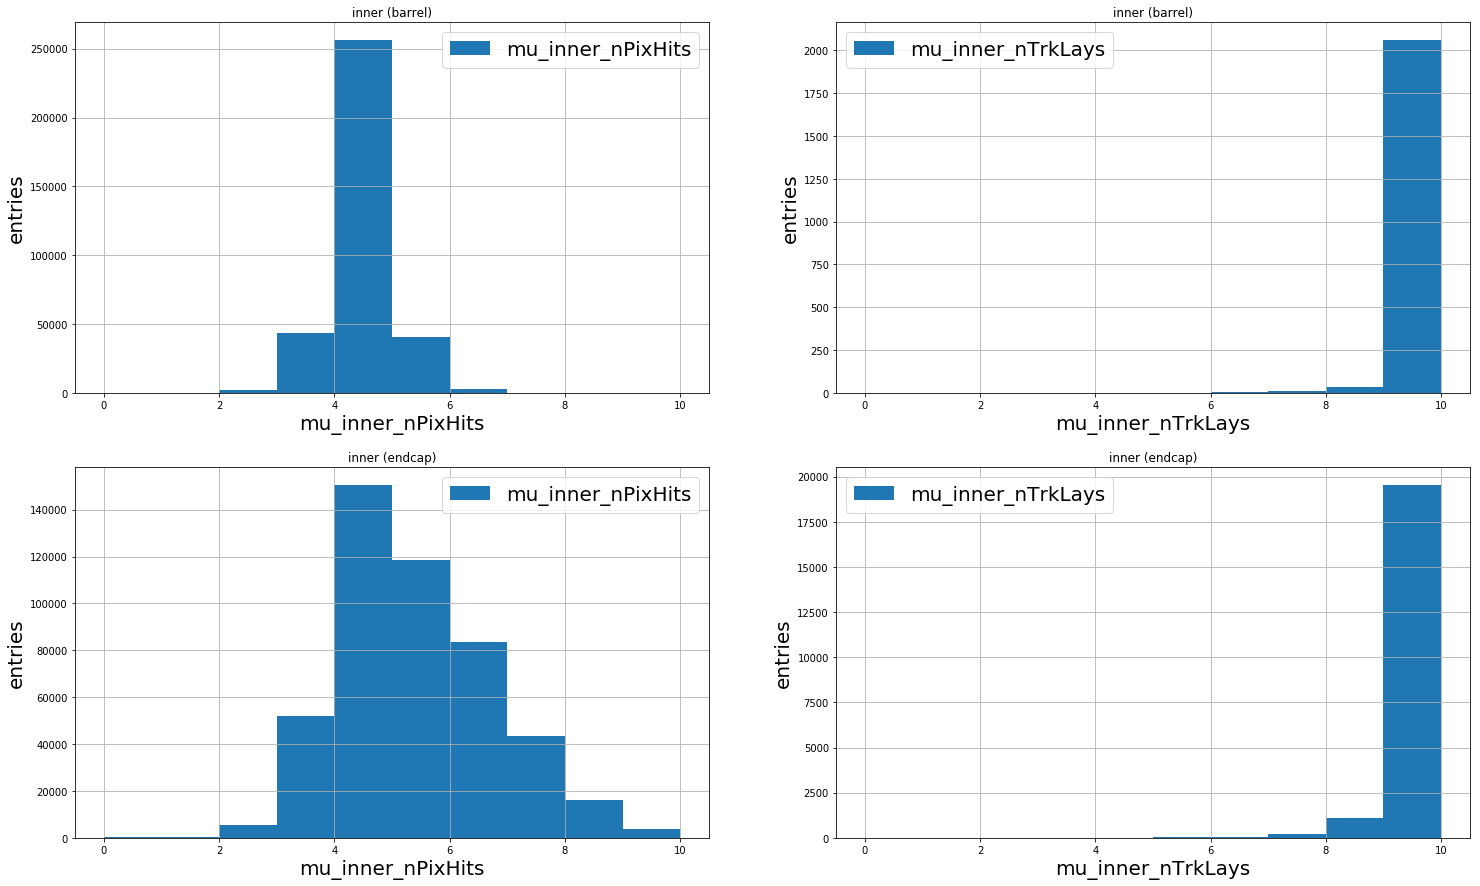

In [7]:
fig, axs = plt.subplots(2, 2, figsize = (25, 15))
plotQuantity(axs[0][0], data_f, "mu_inner_nPixHits", True, [0, 10], 10)
plotQuantity(axs[0][1], data_f, "mu_inner_nTrkLays", True, [0, 10], 10)
plotQuantity(axs[1][0], data_f, "mu_inner_nPixHits", False, [0, 10], 10)
plotQuantity(axs[1][1], data_f, "mu_inner_nTrkLays", False, [0, 10], 10)


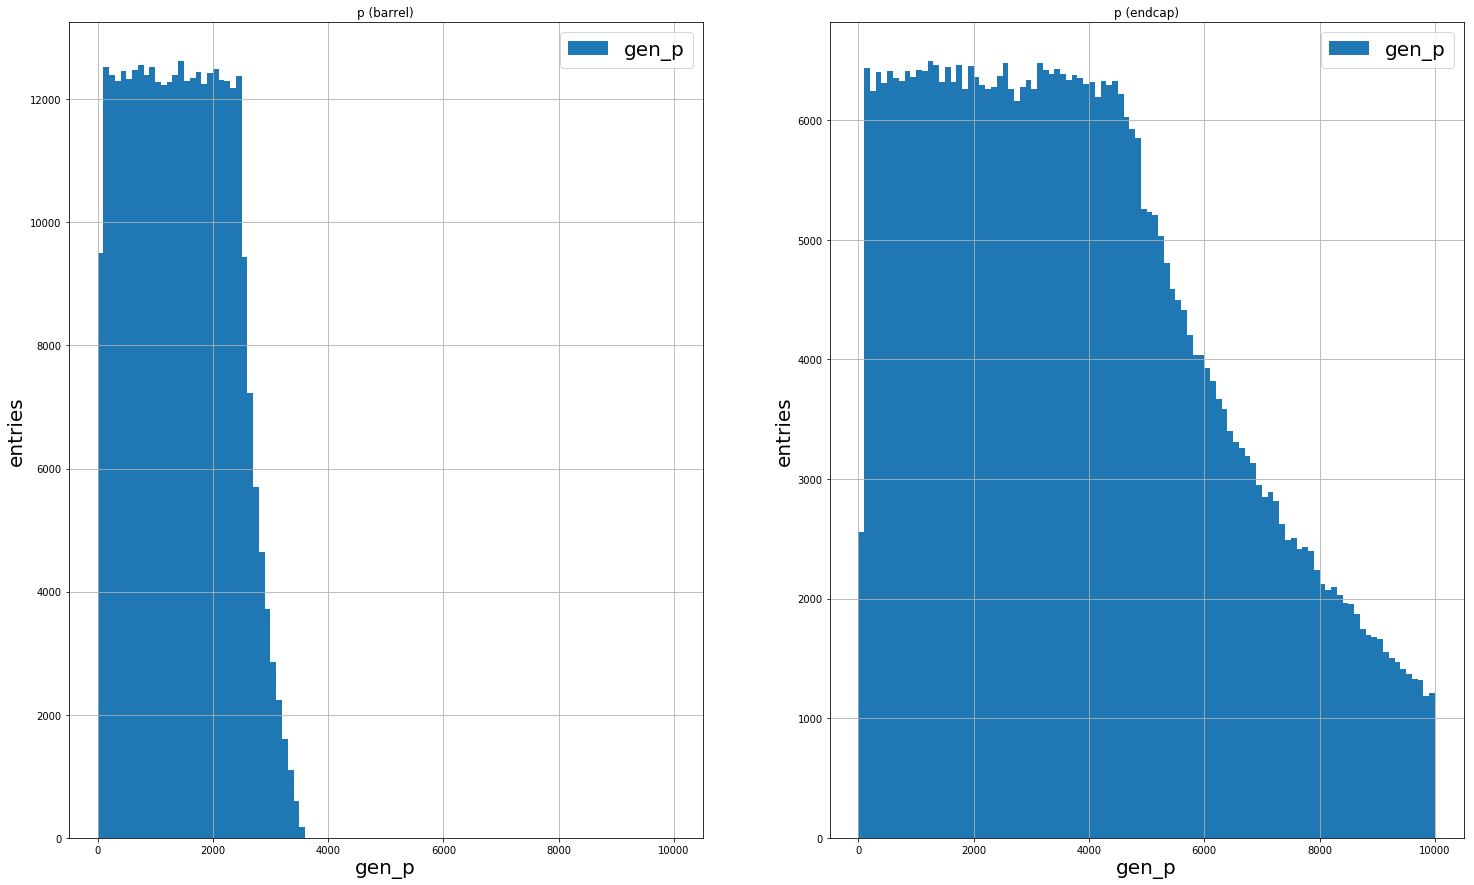

In [8]:
fig, axs = plt.subplots(1, 2, figsize = (25, 15))
plotQuantity(axs[0], data_f, "gen_p", True)
plotQuantity(axs[1], data_f, "gen_p", False)

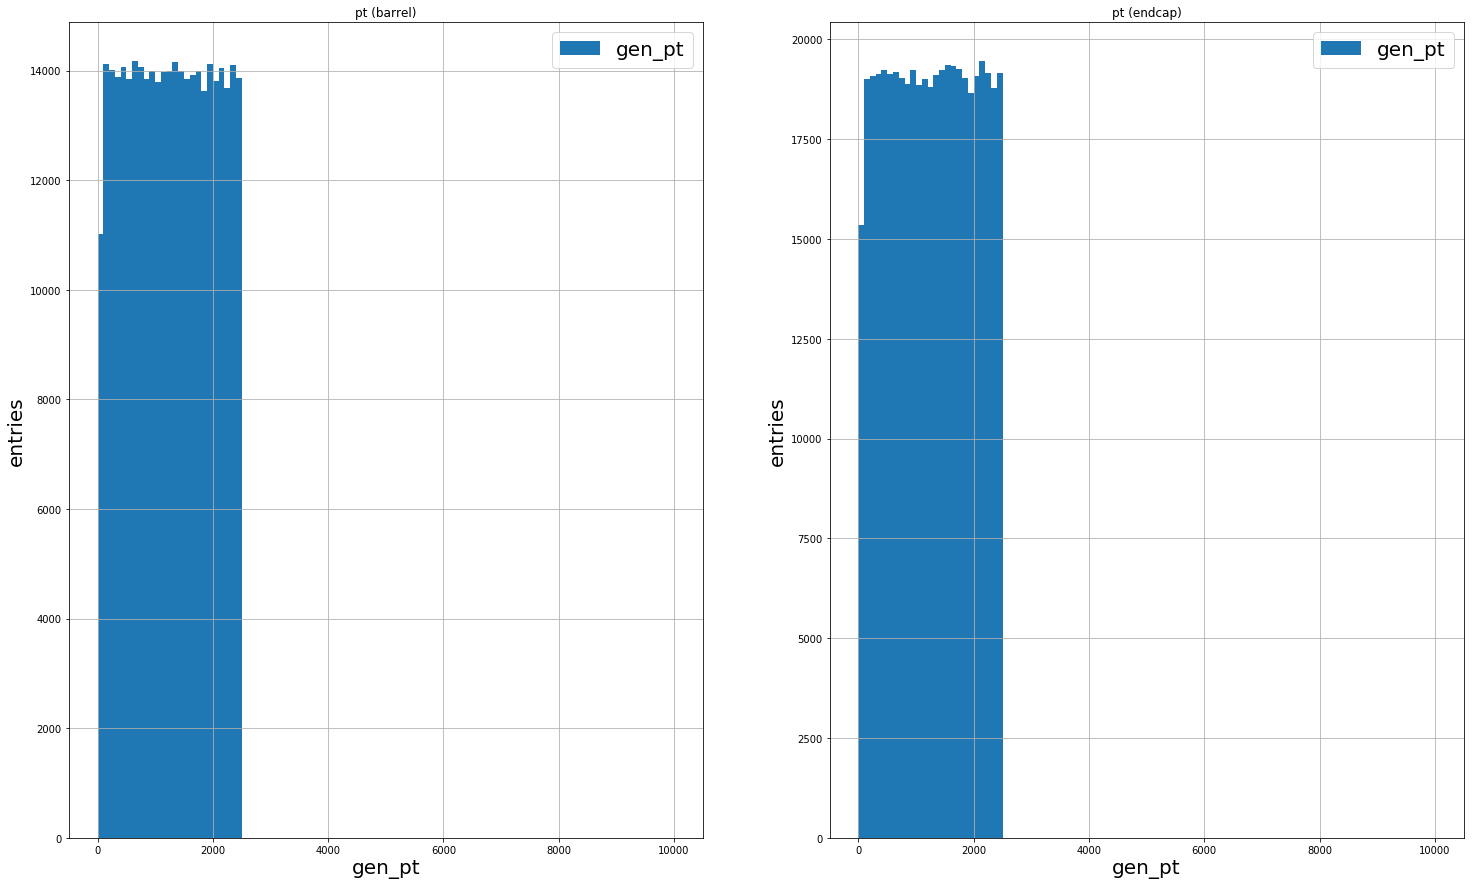

In [9]:
fig, axs = plt.subplots(1, 2, figsize = (25, 15))
plotQuantity(axs[0], data_f, "gen_pt", True)
plotQuantity(axs[1], data_f, "gen_pt", False)

In [10]:
data_f_p_cut = data_f[data_f["gen_p"] < 4000.]
data_f_p_cut.shape

(708295, 68)

In [11]:
def res(data_f, gen_name, refit_name):
    return (data_f[refit_name] - data_f[gen_name]) / data_f[gen_name]

In [12]:
for refit in REFITS:
    data_f_p_cut["mu_" + refit + "_qOverPtRes"] = res(data_f_p_cut,
                                                      "gen_qOverPt",
                                                      "mu_" + refit + "_qOverPt")

In [13]:
def plotQuantityScatter(plt, data_f, x_name, y_name, is_barrel, ranges=[[-5., 5.], [-5., 5.]]):
    if is_barrel:
        data_f_eta_cut = data_f[(np.abs(data_f["gen_eta"]) < BARREL_MAX_ETA)]
    else:
        data_f_eta_cut = data_f[(np.abs(data_f["gen_eta"]) > ENDCAP_MIN_ETA)]
        
    plt.hist2d(data_f_eta_cut[x_name],
               data_f_eta_cut[y_name],
               range=ranges,
               bins=100,
               norm=colors.LogNorm())
    
    plt.set_title(y_name.split("_")[1] 
                  + " vs " + x_name.split("_")[1] 
                  + (" (barrel)" if is_barrel else " (endcap)"),
                 fontsize=20)

    plt.set_xlabel(x_name, fontsize=20)
    plt.set_ylabel(y_name, fontsize=20)
    
    plt.grid(True)

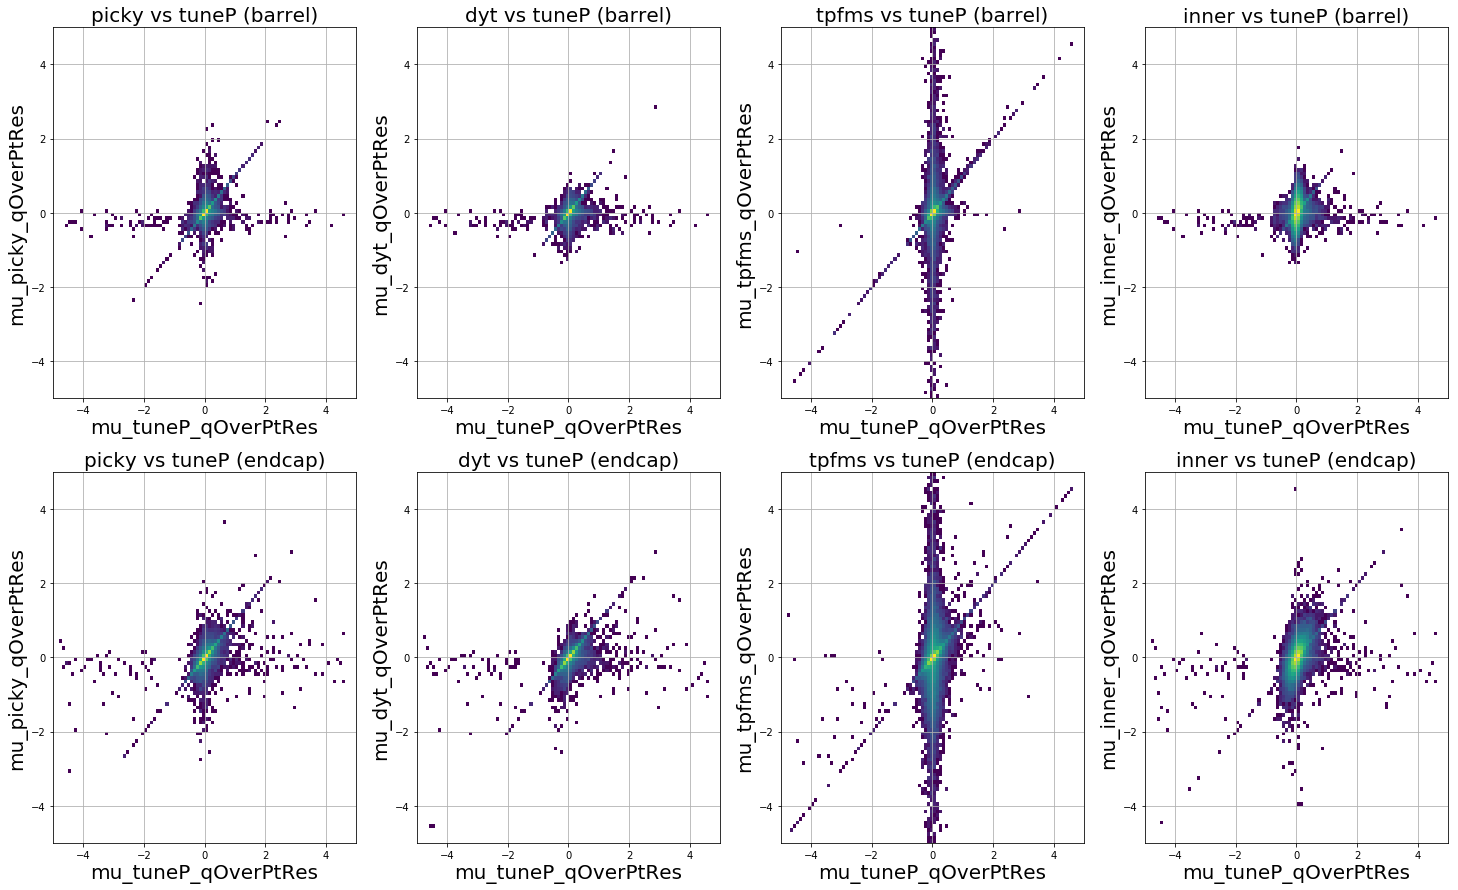

In [14]:
fig, axs = plt.subplots(2, 4, figsize = (25, 15))
plotQuantityScatter(axs[0][0], data_f_p_cut, "mu_tuneP_qOverPtRes", "mu_picky_qOverPtRes", True)
plotQuantityScatter(axs[0][1], data_f_p_cut, "mu_tuneP_qOverPtRes", "mu_dyt_qOverPtRes",   True)
plotQuantityScatter(axs[0][2], data_f_p_cut, "mu_tuneP_qOverPtRes", "mu_tpfms_qOverPtRes", True)
plotQuantityScatter(axs[0][3], data_f_p_cut, "mu_tuneP_qOverPtRes", "mu_inner_qOverPtRes", True)
plotQuantityScatter(axs[1][0], data_f_p_cut, "mu_tuneP_qOverPtRes", "mu_picky_qOverPtRes", False)
plotQuantityScatter(axs[1][1], data_f_p_cut, "mu_tuneP_qOverPtRes", "mu_dyt_qOverPtRes",   False)
plotQuantityScatter(axs[1][2], data_f_p_cut, "mu_tuneP_qOverPtRes", "mu_tpfms_qOverPtRes", False)
plotQuantityScatter(axs[1][3], data_f_p_cut, "mu_tuneP_qOverPtRes", "mu_inner_qOverPtRes", False)

fig.savefig(os.path.join(OUTPUT_FOLDER, "qOverPtRes_refits_vs_tuneP.pdf"))

In [15]:
def plotAndFitQuantity(plt, data_f, name, is_barrel, range_x=[-0.35, 0.35]):
    if is_barrel:
        data_f_eta_cut = data_f[(np.abs(data_f["gen_eta"]) < BARREL_MAX_ETA)]
    else:
        data_f_eta_cut = data_f[(np.abs(data_f["gen_eta"]) > ENDCAP_MIN_ETA)]
        
    n_outliers = float(np.count_nonzero(np.abs(data_f_eta_cut[name]) > FR_OUTLIERS))
    frac_outliers = n_outliers / len(data_f_eta_cut[name]) * 100
    frac_outliers_err = frac_outliers / np.sqrt(n_outliers)
    
    lab = r"outliers (%) : {:5.2f} $\pm$ {:4.2f}".format(frac_outliers,
                                                      frac_outliers_err)
    
    counts, bins, bars = plt.hist(data_f_eta_cut[name],
                                  range = [-5.,5.], 
                                  bins = 2000,
                                  # log = True,
                                  label = lab)
    
    fit_x = (bins[:-1] + bins[1:]) / 2.

    fit_f = VoigtModel()
    params = fit_f.guess(counts[985:1015], x = fit_x[985:1015])
    out = fit_f.fit(counts[985:1015], params, x = fit_x[985:1015])
    fit_y = fit_f.eval(out.params, x = fit_x[985:1015])
    
    fit_sigma = out.params["sigma"].value
    lab = "fit sigma : {:5.3f}".format(fit_sigma)

    plt.plot(fit_x[985:1015], 
             fit_y, 
             color = "orange", 
             linestyle = "dashed", 
             label = lab)
    
    plt.set_title(name.split("_")[1] 
                  + (" (barrel)" if is_barrel else " (endcap)"),
                 fontsize=20)
    plt.set_xlabel(name, fontsize=20)
    plt.set_ylabel("")
    plt.set(xlim = range_x)

    plt.legend(loc = "best", fontsize=14)
    plt.grid(True)

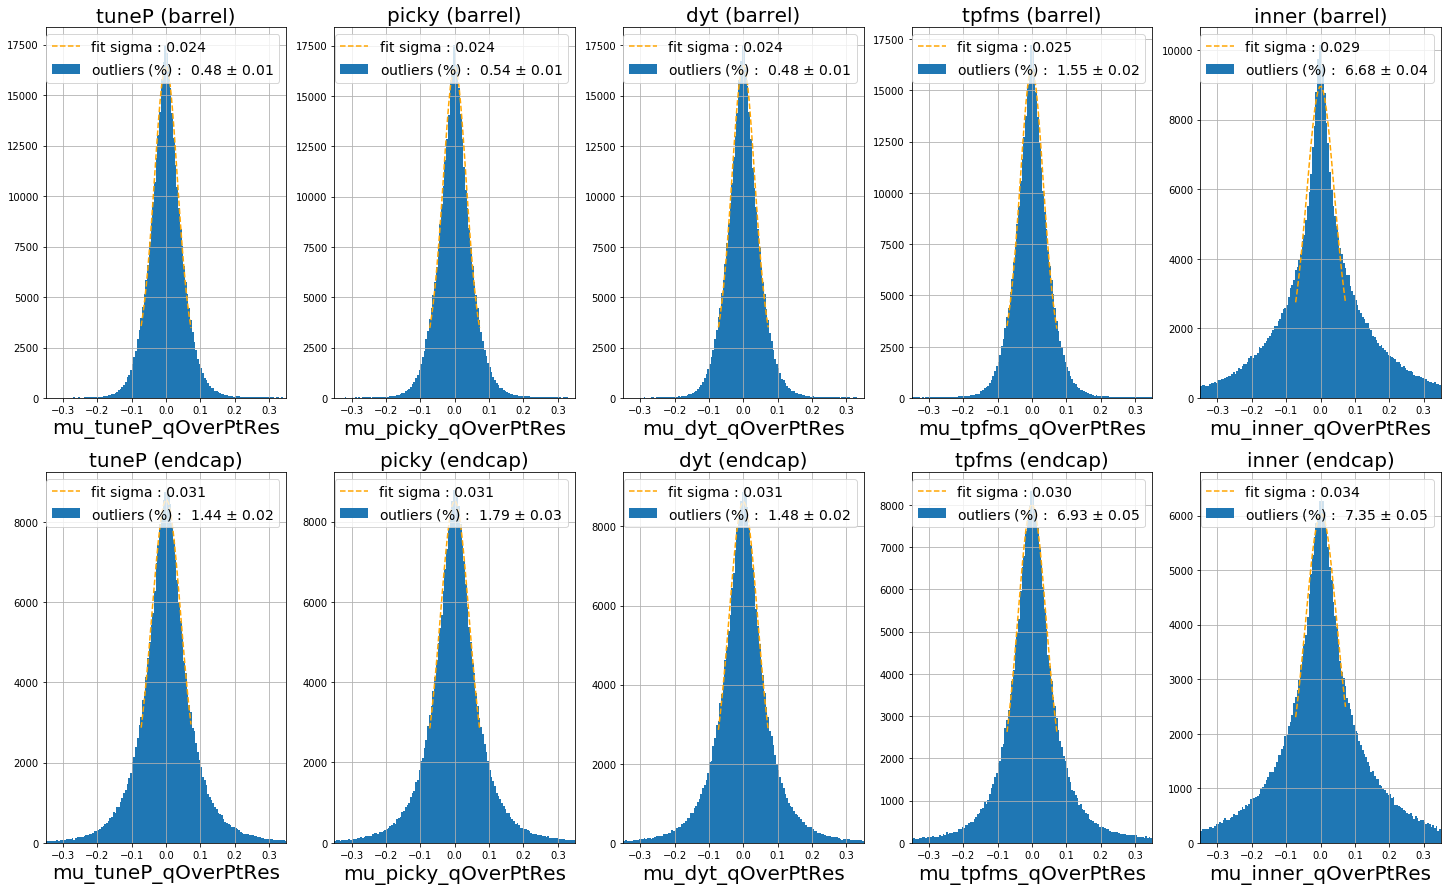

In [16]:
fig, axs = plt.subplots(2, 5, figsize = (25, 15))
plotAndFitQuantity(axs[0][0], data_f_p_cut, "mu_tuneP_qOverPtRes", True)
plotAndFitQuantity(axs[0][1], data_f_p_cut, "mu_picky_qOverPtRes", True)
plotAndFitQuantity(axs[0][2], data_f_p_cut, "mu_dyt_qOverPtRes",   True)
plotAndFitQuantity(axs[0][3], data_f_p_cut, "mu_tpfms_qOverPtRes", True)
plotAndFitQuantity(axs[0][4], data_f_p_cut, "mu_inner_qOverPtRes", True)
plotAndFitQuantity(axs[1][0], data_f_p_cut, "mu_tuneP_qOverPtRes", False)
plotAndFitQuantity(axs[1][1], data_f_p_cut, "mu_picky_qOverPtRes", False)
plotAndFitQuantity(axs[1][2], data_f_p_cut, "mu_dyt_qOverPtRes",   False)
plotAndFitQuantity(axs[1][3], data_f_p_cut, "mu_tpfms_qOverPtRes", False)
plotAndFitQuantity(axs[1][4], data_f_p_cut, "mu_inner_qOverPtRes", False)

fig.savefig(os.path.join(OUTPUT_FOLDER, "qOverPtRes_refits.pdf"))

In [17]:
def plotOutliersVsP(plt, data_f, name, col, is_barrel):
    if is_barrel:
        data_f_eta_cut = data_f[(np.abs(data_f["gen_eta"]) < BARREL_MAX_ETA)] 
    else: 
        data_f_eta_cut = data_f[(np.abs(data_f["gen_eta"]) > ENDCAP_MIN_ETA)]

    x = np.array([], dtype = np.float32)
    y = np.array([], dtype = np.float32)
    y_err = np.array([], dtype = np.float32)
    
    for bin_min, bin_max in zip(P_BINS[:-1], P_BINS[1:]):
        data_f_bin = data_f_eta_cut[(data_f_eta_cut["gen_p"] > bin_min) & \
                                    (data_f_eta_cut["gen_p"] < bin_max)]
        n_outliers_bin = float(np.count_nonzero(np.abs(data_f_bin[name]) > FR_OUTLIERS))
        frac_outliers_bin = n_outliers_bin / max(len(data_f_bin[name]), 1) * 100
        x = np.append(x, data_f_bin["gen_p"].mean())
        y = np.append(y, frac_outliers_bin)
        y_err = np.append(y_err, frac_outliers_bin / max(np.sqrt(n_outliers_bin), 1) )
    
    plt.set_title("barrel" if is_barrel else " endcap",fontsize=20)
    
    plt.errorbar(x, y,
                 yerr = y_err,
                 color = col, 
                 label = name.split("_")[1])
    
    plt.set_xlabel("gen_p", fontsize=20)
    plt.set_ylabel("% of outliers", fontsize=20)

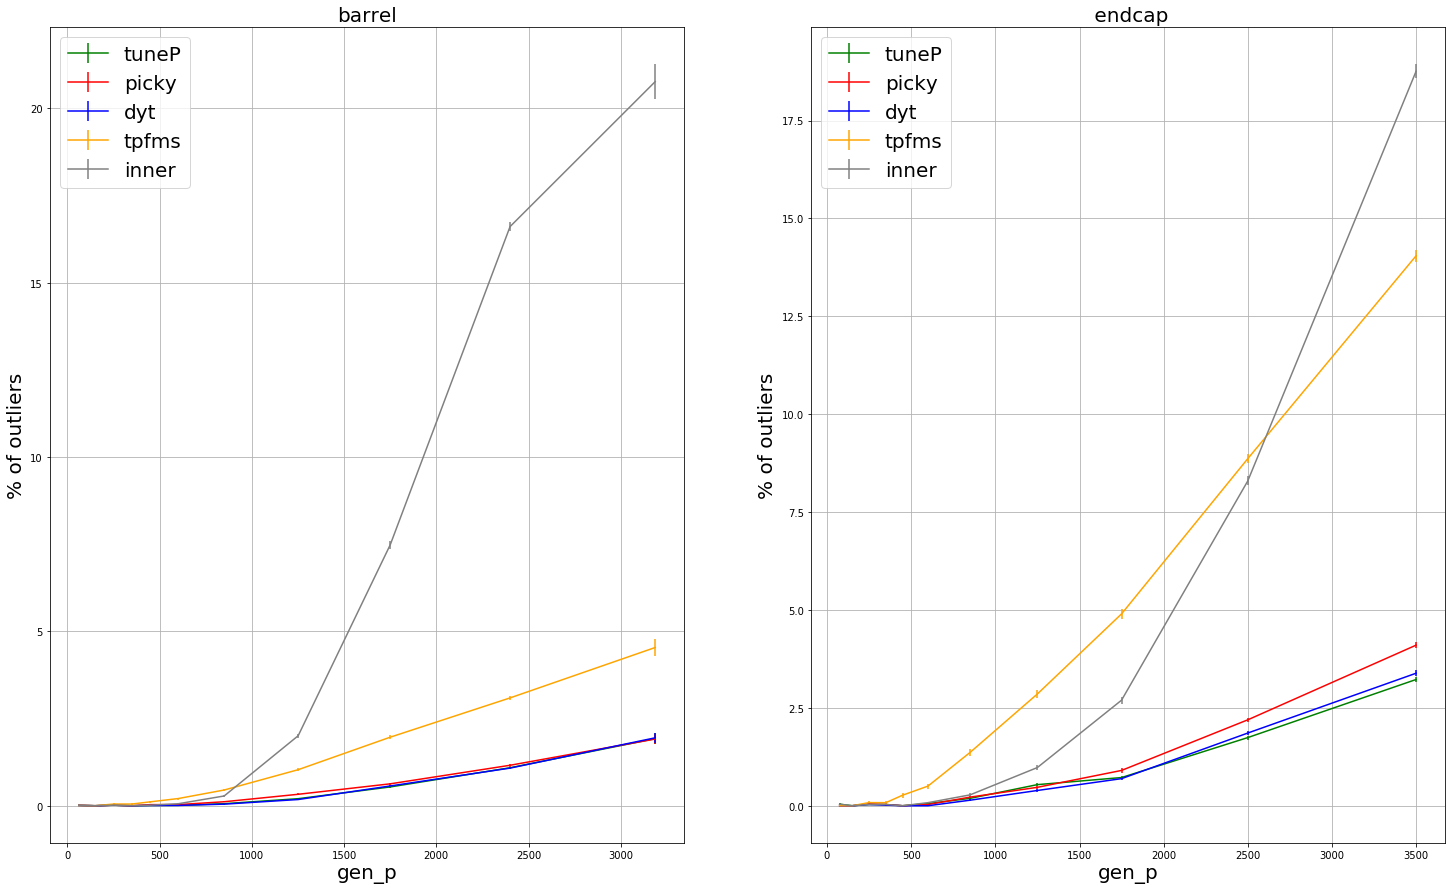

In [18]:
fig, axs = plt.subplots(1, 2, figsize = (25, 15))
plotOutliersVsP(axs[0], data_f_p_cut, "mu_tuneP_qOverPtRes", "green",  True)
plotOutliersVsP(axs[0], data_f_p_cut, "mu_picky_qOverPtRes", "red",    True)
plotOutliersVsP(axs[0], data_f_p_cut, "mu_dyt_qOverPtRes",   "blue",   True)
plotOutliersVsP(axs[0], data_f_p_cut, "mu_tpfms_qOverPtRes", "orange", True)
plotOutliersVsP(axs[0], data_f_p_cut, "mu_inner_qOverPtRes", "grey",   True)
plotOutliersVsP(axs[1], data_f_p_cut, "mu_tuneP_qOverPtRes", "green",  False)
plotOutliersVsP(axs[1], data_f_p_cut, "mu_picky_qOverPtRes", "red",    False)
plotOutliersVsP(axs[1], data_f_p_cut, "mu_dyt_qOverPtRes",   "blue",   False)
plotOutliersVsP(axs[1], data_f_p_cut, "mu_tpfms_qOverPtRes", "orange", False)
plotOutliersVsP(axs[1], data_f_p_cut, "mu_inner_qOverPtRes", "grey",   False)

axs[0].legend(loc = "best", fontsize=20)
axs[0].grid(True)

axs[1].legend(loc = "best", fontsize=20)
axs[1].grid(True)

fig.savefig(os.path.join(OUTPUT_FOLDER, "outliersVsPt_refits.pdf"))

In [19]:
def plotRMSVsP(plt, data_f, name, col, is_barrel):
    if is_barrel:
        data_f_eta_cut = data_f[(np.abs(data_f["gen_eta"]) < BARREL_MAX_ETA)]
    else:
        data_f_eta_cut = data_f[(np.abs(data_f["gen_eta"]) > ENDCAP_MIN_ETA)]

    x = np.array([], dtype = np.float32)
    y = np.array([], dtype = np.float32)
    y_err = np.array([], dtype = np.float32)
    
    for bin_min, bin_max in zip(P_BINS[:-1],P_BINS[1:]):
        data_f_pre_bin = data_f_eta_cut[(data_f_eta_cut["gen_p"] > bin_min) & \
                                        (data_f_eta_cut["gen_p"] < bin_max)]
        data_f_bin = data_f_pre_bin[(data_f_pre_bin[name] > -0.25) & \
                                    (data_f_pre_bin[name] < 0.25)]        
        x = np.append(x, data_f_bin["gen_p"].mean())
        y = np.append(y, data_f_bin[name].std())
        y_err = np.append(y_err, 0) # CB fix me
    
    plt.set_title("barrel" if is_barrel else " endcap", fontsize=20)
    
    plt.errorbar(x, y,
                 yerr = y_err,
                 color = col, 
                 label = name.split("_")[1])
    
    plt.set_xlabel("gen_p", fontsize=20)
    plt.set_ylabel("rms in [-0.25:0.25]", fontsize=20)

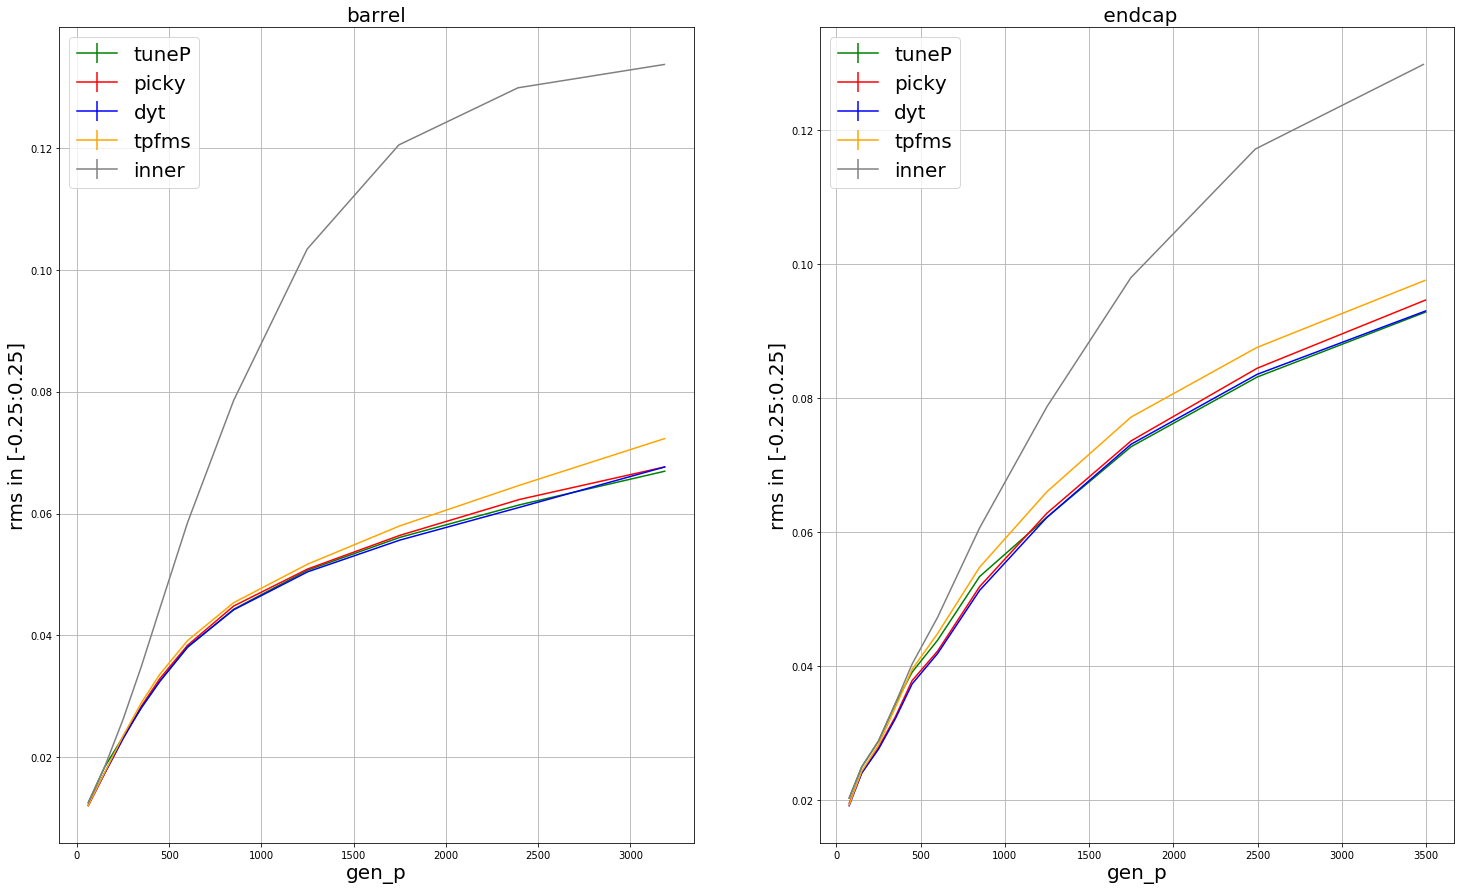

In [20]:
fig, axs = plt.subplots(1, 2, figsize = (25, 15))
plotRMSVsP(axs[0], data_f_p_cut, "mu_tuneP_qOverPtRes", "green",  True)
plotRMSVsP(axs[0], data_f_p_cut, "mu_picky_qOverPtRes", "red",    True)
plotRMSVsP(axs[0], data_f_p_cut, "mu_dyt_qOverPtRes",   "blue",   True)
plotRMSVsP(axs[0], data_f_p_cut, "mu_tpfms_qOverPtRes", "orange", True)
plotRMSVsP(axs[0], data_f_p_cut, "mu_inner_qOverPtRes", "grey",   True)
plotRMSVsP(axs[1], data_f_p_cut, "mu_tuneP_qOverPtRes", "green",  False)
plotRMSVsP(axs[1], data_f_p_cut, "mu_picky_qOverPtRes", "red",    False)
plotRMSVsP(axs[1], data_f_p_cut, "mu_dyt_qOverPtRes",   "blue",   False)
plotRMSVsP(axs[1], data_f_p_cut, "mu_tpfms_qOverPtRes", "orange", False)
plotRMSVsP(axs[1], data_f_p_cut, "mu_inner_qOverPtRes", "grey",   False)

axs[0].legend(loc="best", fontsize=20)
axs[0].grid(True)

axs[1].legend(loc="best", fontsize=20)
axs[1].grid(True)

fig.savefig(os.path.join(OUTPUT_FOLDER, "rmsVsPt_refits.pdf"))

In [21]:
def getBestRefit(picky, dyt, tpfms, inner, gen, gain):
    i_best = 0
    best = dyt
    if (abs(best) - abs(picky)) > gain: 
        i_best = 1
        best = picky
    if (abs(best) - abs(tpfms)) > gain: 
        i_best = 2
        best = tpfms
    if (abs(best) - abs(inner)) > gain: 
        i_best = 3
        best = inner
    return i_best

In [22]:
def getBestRefitArr(data_f, q, gen_q, gain):
    best_refits = np.array([getBestRefit(picky, dyt, tpfms, inner, gen, gain) \
                            for picky, dyt, tpfms, inner, gen \
                            in zip(data_f["mu_picky_" + q],
                                   data_f["mu_dyt_" + q],
                                   data_f["mu_tpfms_" + q],
                                   data_f["mu_inner_" + q],
                                   data_f[gen_q])])
    return best_refits

In [23]:
data_f_p_cut["mu_bestRefit"] = getBestRefitArr(data_f_p_cut,
                                               "qOverPtRes",
                                               "gen_qOverPt", 
                                               Q_OVER_PT_RES_GAIN)

In [24]:
# print data_f["mu_bestRefit"]

In [25]:
quantities_for_training = ["mu_eta",
                           "mu_picky_chi2",
                           "mu_picky_ptErrOverPt",
                           "mu_picky_nPixHits",
                           "mu_picky_nTrkLays",
                           "mu_picky_nMuHits",
                           "mu_dyt_chi2",
                           "mu_dyt_ptErrOverPt",
                           "mu_dyt_nPixHits",
                           "mu_dyt_nTrkLays",
                           "mu_dyt_nMuHits",
                           "mu_tpfms_chi2",
                           "mu_tpfms_ptErrOverPt",
                           "mu_tpfms_nPixHits",
                           "mu_tpfms_nTrkLays",
                           "mu_tpfms_nMuHits",
                           "mu_inner_chi2",
                           "mu_inner_ptErrOverPt",
                           "mu_inner_nPixHits",
                           "mu_inner_nTrkLays",
                           "mu_inner_nMuHits",
                           "mu_nDigis_CSC_st1",
                           "mu_nDigis_CSC_st2",
                           "mu_nDigis_CSC_st3",
                           "mu_nDigis_CSC_st4",
                           "mu_nDigis_DT_st1",
                           "mu_nDigis_DT_st2",
                           "mu_nDigis_DT_st3",
                           "mu_nDigis_DT_st4",
                           "mu_pull_CSC_st1",
                           "mu_pull_CSC_st2",
                           "mu_pull_CSC_st3",
                           "mu_pull_CSC_st4",
                           "mu_pull_DT_st1",
                           "mu_pull_DT_st2",
                           "mu_pull_DT_st3",
                           "mu_pull_DT_st4"]

In [26]:
data_f_train, data_f_test = train_test_split(data_f_p_cut, test_size=0.25, random_state=1000429)

In [27]:
def getBestRefitVal(dyt, picky, tpfms, inner, pred_refit):
    refits = [dyt, picky, tpfms, inner]
    return refits[pred_refit]

In [28]:
def getBestRefitValArr(data_f, q, pred_refits):
    bestRefitVals = np.array([getBestRefitVal(dyt, picky, tpfms, inner, pred_refit) \
                             for dyt, picky, tpfms, inner, pred_refit \
                             in zip(data_f["mu_dyt_" + q],
                                    data_f["mu_picky_" + q],
                                    data_f["mu_tpfms_" + q],
                                    data_f["mu_inner_" + q],
                                    pred_refits)])
    return bestRefitVals

In [29]:
def countFracOfOutliers(x_train, y_train, fr_outliers = FR_OUTLIERS):
    best_refits = getBestRefitValArr(x_train, "qOverPtRes", y_train)

    n_outliers = float(np.count_nonzero(np.abs(best_refits) > fr_outliers))
    frac_outliers = n_outliers / max(len(best_refits), 1) * 100
    frac_outliers_err = frac_outliers / max(np.sqrt(n_outliers), 1)

    return [frac_outliers, frac_outliers_err]

In [30]:
model_pars   = {"max_depth"    : [10, 30, 100],
                "n_estimators" : [10, 30, 100],
                "bootstrap"    : [True, False],
                "max_features" : ["auto", "sqrt", "log2"],
                "criterion"    : ["gini", "entropy"],
                "res_gain"     : [0.05]}

data_f_train_val, data_f_val = train_test_split(data_f_train, 
                                                test_size=0.1, 
                                                random_state=1000429)

validation_scores = {}

for max_depth in model_pars["max_depth"]:
    for n_estimators in model_pars["n_estimators"]:
        for bootstrap in model_pars["bootstrap"]:
            for max_features in model_pars["max_features"]:
                for criterion in model_pars["criterion"]:
                    for res_gain in model_pars["res_gain"]:
                        config_tag = str(max_depth) \
                                     + "_" + str(n_estimators) \
                                     + "_" + str(bootstrap) \
                                     + "_" + str(max_features) \
                                     + "_" + str(criterion) \
                                     + "_" + str(res_gain)
                                     
                        data_f_train_val["mu_bestRefit" + str(res_gain)] = getBestRefitArr(data_f_train_val,
                                                                                           "qOverPtRes",
                                                                                           "gen_qOverPt", 
                                                                                           res_gain)
                        rf_clf_pars = RandomForestClassifier(max_depth = max_depth,
                                                             n_estimators = n_estimators,
                                                             bootstrap = bootstrap,
                                                             max_features = max_features,
                                                             criterion = criterion,
                                                             n_jobs = -1)

                        rf_clf_pars.fit(data_f_train_val[quantities_for_training], 
                                        data_f_train_val["mu_bestRefit" + str(res_gain)])
                    
                        data_f_val_pred = rf_clf_pars.predict(data_f_val[quantities_for_training])
                    
                        frac_of_outliers = countFracOfOutliers(data_f_val, 
                                                               data_f_val_pred, 
                                                               FR_OUTLIERS)
                    
                        validation_scores[config_tag] = frac_of_outliers
                    
                        print "Variable: {:<25}  -  score: {:5.4f} +/- {:5.2f}".format(config_tag, 
                                                                                       frac_of_outliers[0],
                                                                                       frac_of_outliers[1])

Variable: 10_10_True_auto_gini_0.05  -  score: 0.8490 +/-  0.04
Variable: 10_10_True_auto_entropy_0.05  -  score: 0.8753 +/-  0.04
Variable: 10_10_True_sqrt_gini_0.05  -  score: 0.8622 +/-  0.04
Variable: 10_10_True_sqrt_entropy_0.05  -  score: 0.8678 +/-  0.04
Variable: 10_10_True_log2_gini_0.05  -  score: 0.8734 +/-  0.04
Variable: 10_10_True_log2_entropy_0.05  -  score: 0.8885 +/-  0.04
Variable: 10_10_False_auto_gini_0.05  -  score: 0.8603 +/-  0.04
Variable: 10_10_False_auto_entropy_0.05  -  score: 0.8753 +/-  0.04
Variable: 10_10_False_sqrt_gini_0.05  -  score: 0.8396 +/-  0.04
Variable: 10_10_False_sqrt_entropy_0.05  -  score: 0.8810 +/-  0.04
Variable: 10_10_False_log2_gini_0.05  -  score: 0.8640 +/-  0.04
Variable: 10_10_False_log2_entropy_0.05  -  score: 0.8866 +/-  0.04
Variable: 10_30_True_auto_gini_0.05  -  score: 0.8622 +/-  0.04
Variable: 10_30_True_auto_entropy_0.05  -  score: 0.8734 +/-  0.04
Variable: 10_30_True_sqrt_gini_0.05  -  score: 0.8734 +/-  0.04
Variable: 10_

  0 Configuration 100_100_False_auto_entropy_0.05 : 0.7699 +/- 0.0381
  1 Configuration 100_100_False_auto_gini_0.05   : 0.7661 +/- 0.0380
  3 Configuration 100_100_False_log2_gini_0.05   : 0.7699 +/- 0.0381
  4 Configuration 100_100_False_sqrt_entropy_0.05 : 0.7850 +/- 0.0384
  5 Configuration 100_100_False_sqrt_gini_0.05   : 0.7699 +/- 0.0381
  6 Configuration 100_100_True_auto_entropy_0.05 : 0.7925 +/- 0.0386
  7 Configuration 100_100_True_auto_gini_0.05    : 0.7906 +/- 0.0386
 11 Configuration 100_100_True_sqrt_gini_0.05    : 0.7756 +/- 0.0382
 12 Configuration 100_10_False_auto_entropy_0.05 : 0.7850 +/- 0.0384
 13 Configuration 100_10_False_auto_gini_0.05    : 0.7850 +/- 0.0384
 16 Configuration 100_10_False_sqrt_entropy_0.05 : 0.7925 +/- 0.0386
 17 Configuration 100_10_False_sqrt_gini_0.05    : 0.7906 +/- 0.0386
 22 Configuration 100_10_True_sqrt_entropy_0.05  : 0.7925 +/- 0.0386
 23 Configuration 100_10_True_sqrt_gini_0.05     : 0.7963 +/- 0.0387
 24 Configuration 100_30_False_a

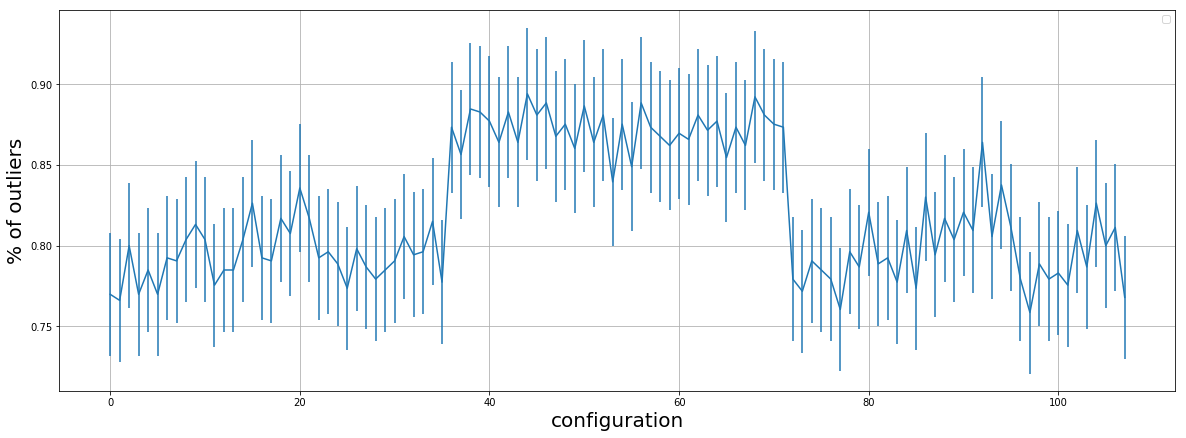

In [31]:
fig_val_pars, axs_val_pars = plt.subplots(1, 1, figsize = (20, 7))

score_vals = np.array([], dtype = np.float32)
score_errs = np.array([], dtype = np.float32)

for config, frac_outilers in sorted(validation_scores.items()):
    score_vals = np.append(score_vals, frac_outilers[0])
    score_errs = np.append(score_errs, frac_outilers[1])
    
axs_val_pars.errorbar(np.arange(0, len(model_pars["max_depth"]) 
                                   * len(model_pars["n_estimators"])
                                   * len(model_pars["bootstrap"])
                                   * len(model_pars["max_features"])
                                   * len(model_pars["criterion"])
                                   * len(model_pars["res_gain"]),
                      1, dtype = np.int32),
                      score_vals,
                      yerr = score_errs)

axs_val_pars.grid(True)
axs_val_pars.legend(loc = 'best')
axs_val_pars.set_xlabel("configuration", fontsize=20)
axs_val_pars.set_ylabel("% of outliers", fontsize=20)

fig_val_pars.savefig(os.path.join(OUTPUT_FOLDER, "random_forest_parameters.pdf"))

i_config = 0
for config, frac_outilers in sorted(validation_scores.items()):
    if frac_outilers[0] < 0.80:
        print "{:3d} Configuration {:30} : {:5.4f} +/- {:5.4f}".format(i_config,
                                                                       config, 
                                                                       frac_outilers[0],
                                                                       frac_outilers[1])
    i_config += 1

In [32]:
# qOverPtRel cut 0.05, gen_p < 4 GeV, outliers 0.3: Configuration 100_30_False_sqrt_gini_0.05 : 0.7906 +/- 0.0386 
rf_clf = RandomForestClassifier(max_depth = 100, 
                                n_estimators = 100,
                                bootstrap = False, 
                                max_features = "sqrt",
                                criterion ="gini")
                    
rf_clf.fit(data_f_train[quantities_for_training],
           data_f_train["mu_bestRefit"])

data_f_test_pred = rf_clf.predict(data_f_test[quantities_for_training])

In [33]:
#print dir(data_f_test_pred)
data_f_test["mu_rf_qOverPtRes"] = getBestRefitValArr(data_f_test, 
                                                     "qOverPtRes", 
                                                     data_f_test_pred)

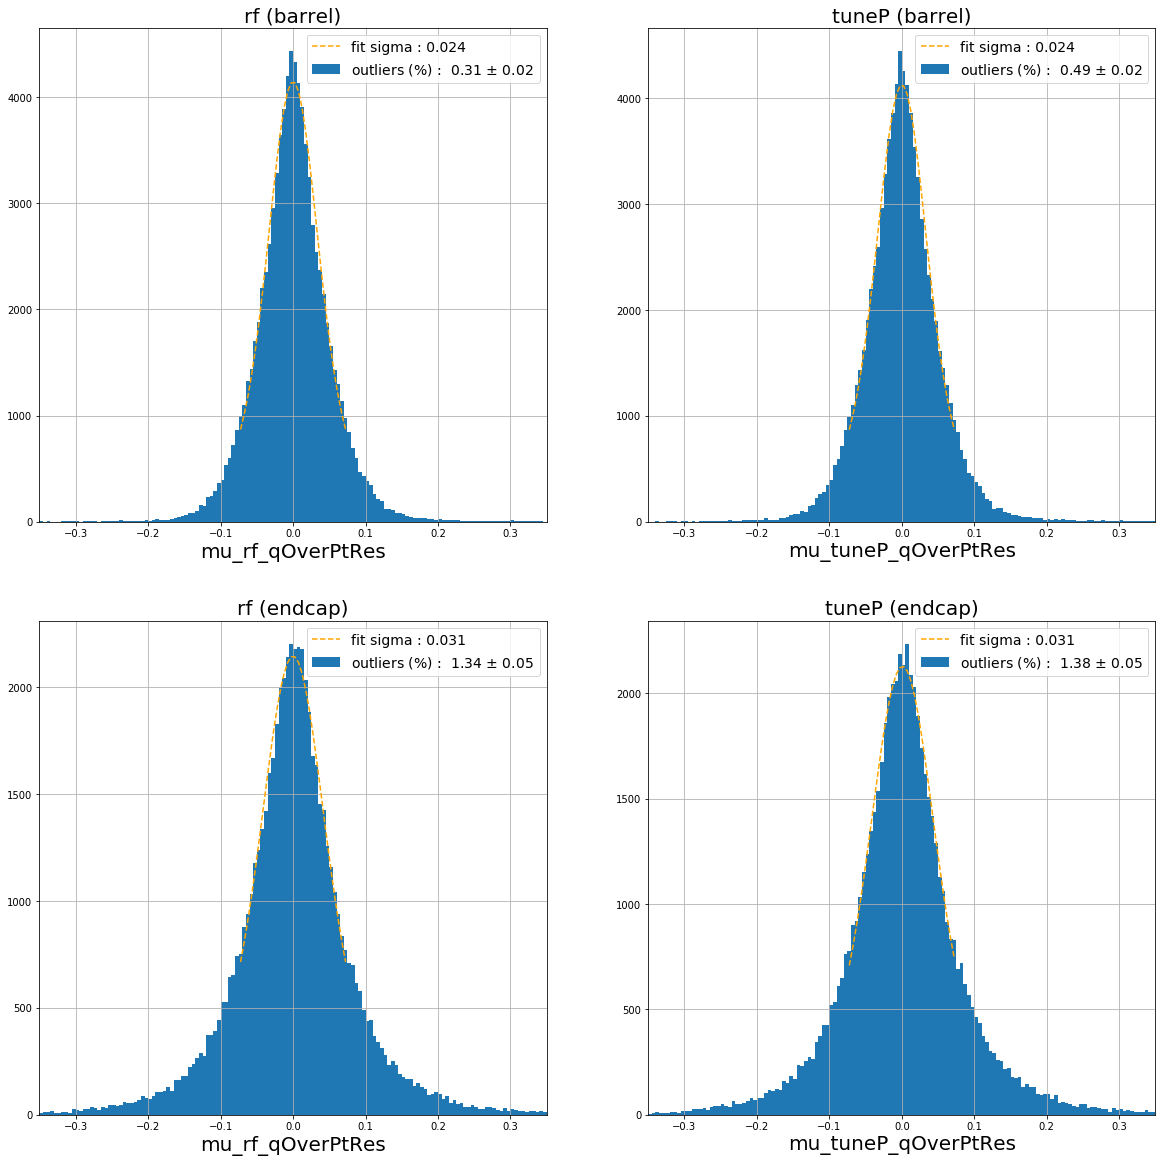

In [34]:
fig, axs = plt.subplots(2, 2, figsize=(20, 20))
plotAndFitQuantity(axs[0][0], data_f_test, "mu_rf_qOverPtRes",    True)
plotAndFitQuantity(axs[0][1], data_f_test, "mu_tuneP_qOverPtRes", True)
plotAndFitQuantity(axs[1][0], data_f_test, "mu_rf_qOverPtRes",    False)
plotAndFitQuantity(axs[1][1], data_f_test, "mu_tuneP_qOverPtRes", False)

fig.savefig(os.path.join(OUTPUT_FOLDER, "qOverPtRes_random_forest.pdf"))

In [35]:
var_map = {}
for var, score in zip(quantities_for_training, rf_clf.feature_importances_):
    var_map[score] = var
    
for score, var in sorted(var_map.items(), reverse=True):
    print "Variable: {:<25}  -  score: {:5.4f}".format(var,score)

Variable: mu_dyt_ptErrOverPt         -  score: 0.0757
Variable: mu_picky_ptErrOverPt       -  score: 0.0630
Variable: mu_tpfms_ptErrOverPt       -  score: 0.0603
Variable: mu_inner_ptErrOverPt       -  score: 0.0573
Variable: mu_picky_chi2              -  score: 0.0525
Variable: mu_tpfms_chi2              -  score: 0.0502
Variable: mu_eta                     -  score: 0.0478
Variable: mu_dyt_chi2                -  score: 0.0478
Variable: mu_inner_chi2              -  score: 0.0462
Variable: mu_dyt_nMuHits             -  score: 0.0383
Variable: mu_picky_nMuHits           -  score: 0.0367
Variable: mu_pull_CSC_st1            -  score: 0.0295
Variable: mu_pull_CSC_st2            -  score: 0.0285
Variable: mu_pull_CSC_st3            -  score: 0.0254
Variable: mu_pull_DT_st1             -  score: 0.0235
Variable: mu_nDigis_CSC_st1          -  score: 0.0235
Variable: mu_nDigis_CSC_st2          -  score: 0.0234
Variable: mu_tpfms_nMuHits           -  score: 0.0233
Variable: mu_pull_CSC_st4   

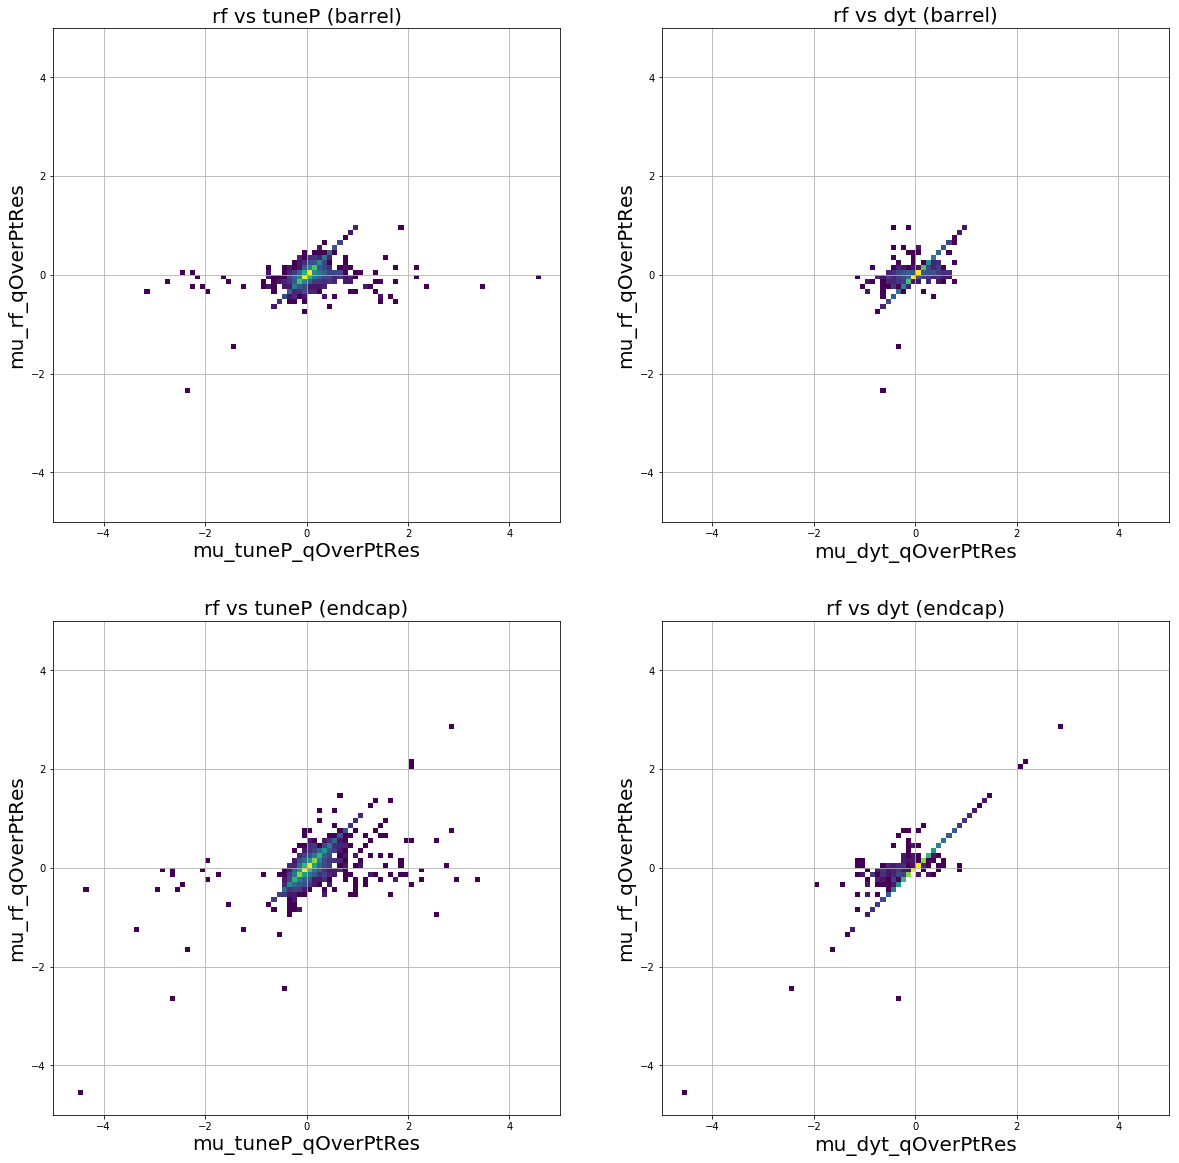

In [36]:
fig, axs = plt.subplots(2, 2, figsize = (20, 20))
plotQuantityScatter(axs[0][0], data_f_test, "mu_tuneP_qOverPtRes", "mu_rf_qOverPtRes", True)
plotQuantityScatter(axs[0][1], data_f_test, "mu_dyt_qOverPtRes",   "mu_rf_qOverPtRes", True)
plotQuantityScatter(axs[1][0], data_f_test, "mu_tuneP_qOverPtRes", "mu_rf_qOverPtRes", False)
plotQuantityScatter(axs[1][1], data_f_test, "mu_dyt_qOverPtRes",   "mu_rf_qOverPtRes", False)

fig.savefig(os.path.join(OUTPUT_FOLDER, "qOverPtRes_random_forest_vs_tuneP.pdf"))

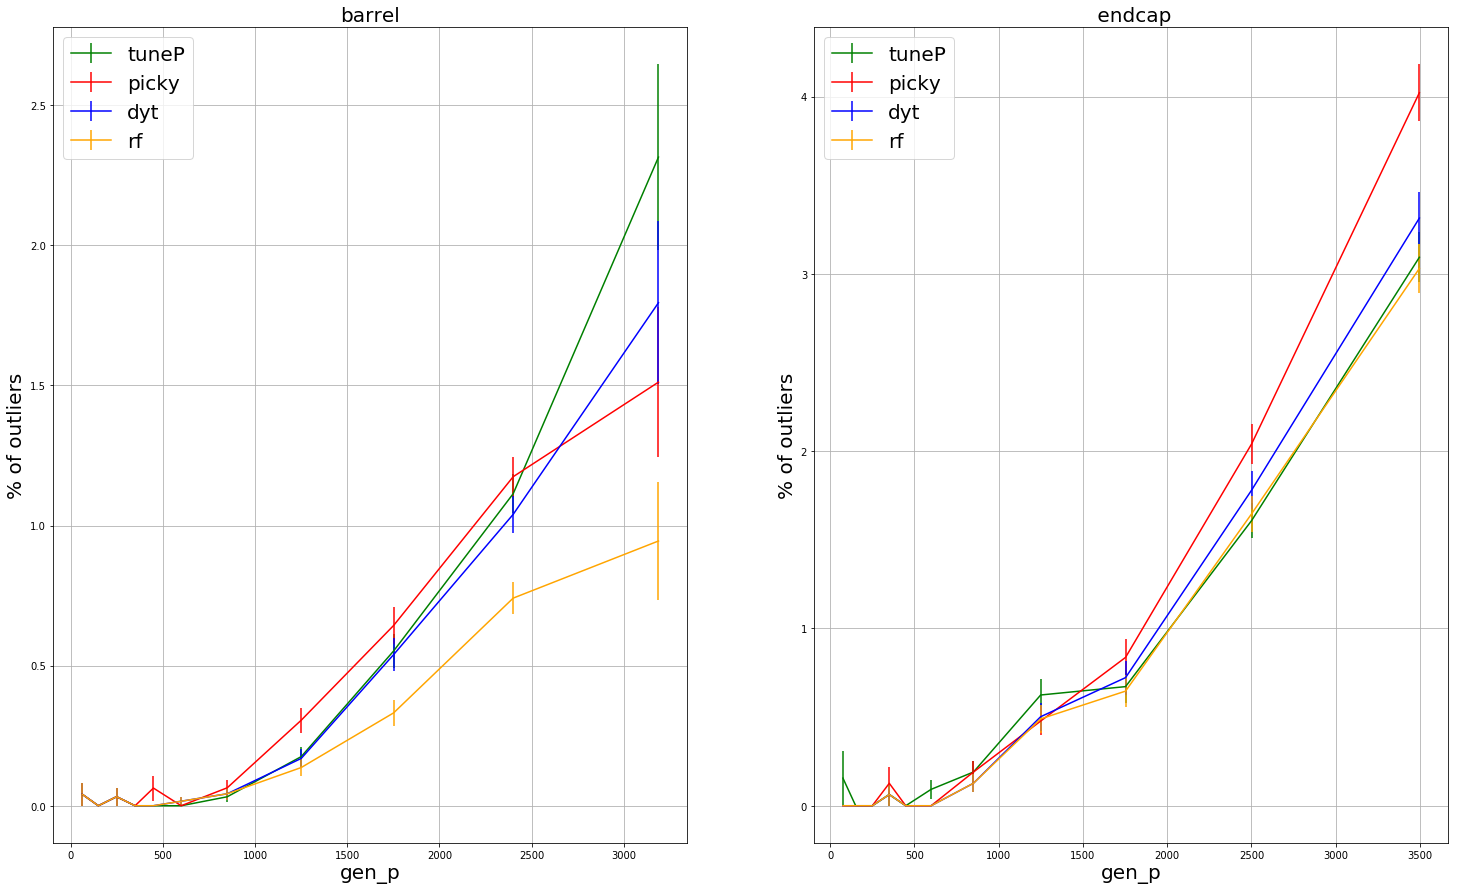

In [37]:
fig, axs = plt.subplots(1, 2, figsize = (25, 15))
plotOutliersVsP(axs[0], data_f_test, "mu_tuneP_qOverPtRes", "green",  True)
plotOutliersVsP(axs[0], data_f_test, "mu_picky_qOverPtRes", "red",    True)
plotOutliersVsP(axs[0], data_f_test, "mu_dyt_qOverPtRes",   "blue",   True)
plotOutliersVsP(axs[0], data_f_test, "mu_rf_qOverPtRes",    "orange", True)
plotOutliersVsP(axs[1], data_f_test, "mu_tuneP_qOverPtRes", "green",  False)
plotOutliersVsP(axs[1], data_f_test, "mu_picky_qOverPtRes", "red",    False)
plotOutliersVsP(axs[1], data_f_test, "mu_dyt_qOverPtRes",   "blue",   False)
plotOutliersVsP(axs[1], data_f_test, "mu_rf_qOverPtRes",    "orange", False)

axs[0].legend(loc = "best", fontsize=20)
axs[0].grid(True)

axs[1].legend(loc = "best", fontsize=20)
axs[1].grid(True)

fig.savefig(os.path.join(OUTPUT_FOLDER, "outliersVsPt_random_forest.pdf"))

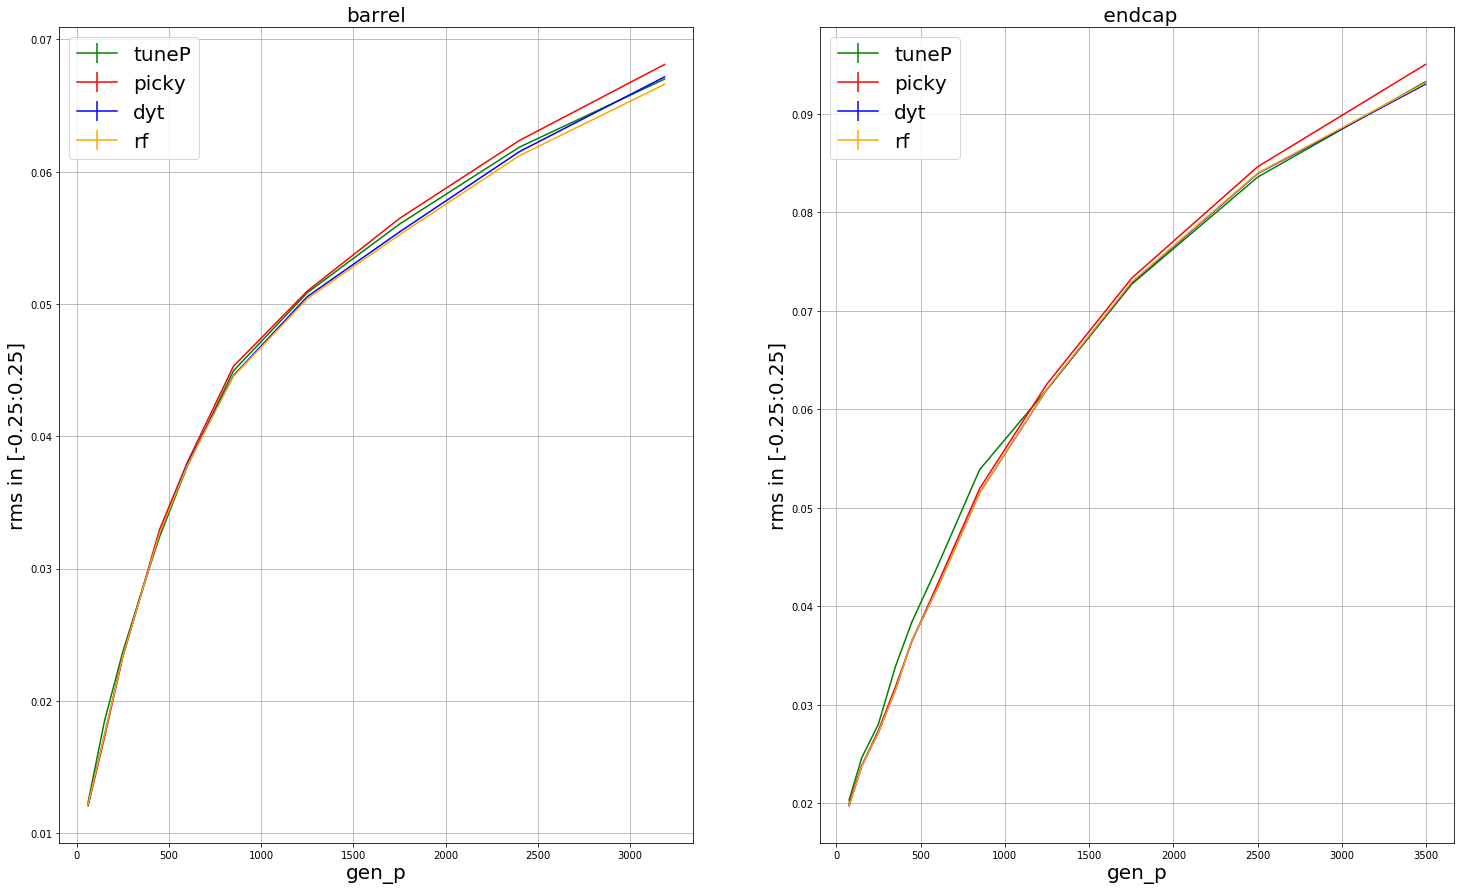

In [38]:
fig, axs = plt.subplots(1, 2, figsize = (25, 15))
plotRMSVsP(axs[0], data_f_test, "mu_tuneP_qOverPtRes", "green",  True)
plotRMSVsP(axs[0], data_f_test, "mu_picky_qOverPtRes", "red",    True)
plotRMSVsP(axs[0], data_f_test, "mu_dyt_qOverPtRes",   "blue",   True)
plotRMSVsP(axs[0], data_f_test, "mu_rf_qOverPtRes",    "orange", True)
plotRMSVsP(axs[1], data_f_test, "mu_tuneP_qOverPtRes", "green",  False)
plotRMSVsP(axs[1], data_f_test, "mu_picky_qOverPtRes", "red",    False)
plotRMSVsP(axs[1], data_f_test, "mu_dyt_qOverPtRes",   "blue",   False)
plotRMSVsP(axs[1], data_f_test, "mu_rf_qOverPtRes",    "orange", False)

axs[0].legend(loc = "best", fontsize=20)
axs[0].grid(True)

axs[1].legend(loc = "best", fontsize=20)
axs[1].grid(True)

fig.savefig(os.path.join(OUTPUT_FOLDER, "rmsVsPt_random_forest.pdf"))